In [4]:
import os
import sys
os.environ["PYSPARK_SUBMIT_ARGS"]='pyspark-shell'
os.environ["PYSPARK_PYTHON"]='python3'
os.environ["SPARK_HOME"]='/opt/cloudera/parcels/SPARK2/lib/spark2/'

spark_home = os.environ.get('SPARK_HOME', None)
if not spark_home:
    raise ValueError('SPARK_HOME environment variable is not set')
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.6-src.zip'))
os.environ["PYSPARK_PYTHON"] = 'python3'
exec(open(os.path.join(spark_home, 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.3.0.cloudera2
      /_/

Using Python version 3.4.3 (default, Nov 17 2016 01:08:31)
SparkSession available as 'spark'.


In [30]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.4/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Пусть вам дан следующий SQL-запрос
```sql

select * from logs l join ips r
on l.ip == r.ip
```

In [2]:
## Выполните этот запрос в Spark SQL, предварительно зарегистрировав таблицы

In [15]:
sql = """
select url, code, region from logs as l join ips as r
on l.ip == r.ip
"""

In [5]:
from pyspark.sql.types import *

In [6]:
log_schema = StructType(fields=[
    StructField("ip", StringType()),
    StructField("timestamp", LongType()),
    StructField("url", StringType()),
    StructField("size", IntegerType()),
    StructField("code", IntegerType()),
    StructField("ua", StringType())
])

In [38]:
log = spark.read.csv("/user/pklemenkov/lectures/x5/lecture06/data/logsM.txt", sep="\t", schema=log_schema).cache()

In [8]:
ip_schema = StructType(fields=[
    StructField("ip", StringType()),
    StructField("region", StringType())
])

In [9]:
ips = spark.read.csv("/user/pklemenkov/lectures/x5/lecture06/data/ipDataM.txt", schema=ip_schema, sep="\t").cache()

In [10]:
log.registerTempTable("logs")

In [11]:
ips.registerTempTable("ips")

In [16]:
spark.sql(sql).take(5)

[Row(url='http://news.rambler.ru/3105700', code=431, region='Irkutsk Oblast'),
 Row(url='http://news.rambler.ru/3105700', code=431, region='Omsk Oblast'),
 Row(url='http://news.rambler.ru/3105700', code=431, region='Nizhny Novgorod Oblast'),
 Row(url='http://news.rambler.ru/3105700', code=431, region='Jewish'),
 Row(url='http://news.rambler.ru/3105700', code=431, region='Kamchatka Krai')]

In [17]:
## Теперь перепешите этот запрос с использованием DataFrame API

In [19]:
log.join(ips, on="ip", how="inner").select("url", "code", "region").take(5)

[Row(url='http://news.rambler.ru/3105700', code=431, region='Irkutsk Oblast'),
 Row(url='http://news.rambler.ru/3105700', code=431, region='Omsk Oblast'),
 Row(url='http://news.rambler.ru/3105700', code=431, region='Nizhny Novgorod Oblast'),
 Row(url='http://news.rambler.ru/3105700', code=431, region='Jewish'),
 Row(url='http://news.rambler.ru/3105700', code=431, region='Kamchatka Krai')]

In [23]:
## Посчитайте гистограмму распределения кодов ответа в логе доступа. Отсуртируйте результат по сумме кодов. Наибольшая сумма сверху

In [25]:
log.groupby("code").count().sort("count", ascending=False).collect()

[Row(code=302, count=323),
 Row(code=307, count=182),
 Row(code=205, count=181),
 Row(code=502, count=181),
 Row(code=504, count=177),
 Row(code=207, count=174),
 Row(code=415, count=174),
 Row(code=403, count=174),
 Row(code=408, count=172),
 Row(code=200, count=170),
 Row(code=505, count=169),
 Row(code=422, count=169),
 Row(code=409, count=167),
 Row(code=503, count=165),
 Row(code=418, count=165),
 Row(code=507, count=164),
 Row(code=301, count=163),
 Row(code=456, count=162),
 Row(code=511, count=161),
 Row(code=226, count=161),
 Row(code=101, count=160),
 Row(code=509, count=159),
 Row(code=426, count=158),
 Row(code=401, count=157),
 Row(code=417, count=155),
 Row(code=105, count=155),
 Row(code=423, count=155),
 Row(code=202, count=154),
 Row(code=100, count=154),
 Row(code=429, count=153),
 Row(code=412, count=153),
 Row(code=201, count=153),
 Row(code=500, count=152),
 Row(code=407, count=152),
 Row(code=510, count=151),
 Row(code=406, count=151),
 Row(code=449, count=150),
 

In [26]:
## Изобразите гистограмму кодов на графике

In [27]:
log_hist = log.groupby("code").count().sort("count", ascending=False).toPandas()

array([[<matplotlib.axes.AxesSubplot object at 0x7f5017185710>]],
      dtype=object)

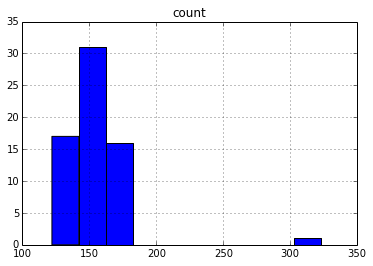

In [33]:
log_hist.hist(column="count")

In [34]:
## Напишите запрос, который вернет распределение доменов среди запросов

In [35]:
import pyspark.sql.functions as F

In [37]:
log

<ufunc 'log'>

In [40]:
log_with_domains = log.withColumn("domain", F.regexp_extract("url", "http:\/\/(.*)\/", 1))

In [41]:
log_with_domains.take(5)

[Row(ip='33.49.147.163', timestamp=20140101014611, url='http://news.rambler.ru/3105700', size=378, code=431, ua='Safari/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Win64; x64; Trident/5.0; .NET CLR 3.5.30729;)', domain='news.rambler.ru'),
 Row(ip='197.72.248.141', timestamp=20140101020306, url='http://news.mail.ru/6344933', size=1412, code=203, ua='Safari/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; .NET CLR 3.5.30729; .NET CLR 3.0.30729;', domain='news.mail.ru'),
 Row(ip='33.49.147.163', timestamp=20140101023103, url='http://lenta.ru/4303000', size=1189, code=451, ua='Chrome/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Win64; x64; Trident/5.0)', domain='lenta.ru'),
 Row(ip='75.208.40.166', timestamp=20140101032909, url='http://newsru.com/3330815', size=60, code=306, ua='Safari/5.0 (Windows; U; MSIE 9.0; Windows NT 8.1; Trident/5.0; .NET4.0E; en-AU)', domain='newsru.com'),
 Row(ip='197.72.248.141', timestamp=20140101033626, url='http://newsru.com/1588977', size=736, code

In [42]:
log_with_domains.groupby("domain").count().collect()

[Row(domain='news.rambler.ru', count=1983),
 Row(domain='news.yandex.ru', count=2015),
 Row(domain='newsru.com', count=2001),
 Row(domain='news.mail.ru', count=2035),
 Row(domain='lenta.ru', count=2058)]

In [44]:
spark.stop()